# KNN with Native CUDA C++ - Comprehensive Analysis

This notebook implements the K-Nearest Neighbors algorithm using raw C++ and CUDA.

**Workflow:**
1.  **Python**: Load multiple datasets and save them to binary files.
2.  **C++ / CUDA**: Read the binary files, compute distances on the GPU, and predict labels.
3.  **Bash**: Compile the CUDA program.
4.  **Python**: Run benchmarks on all datasets and create comprehensive visualizations.

**Datasets:**
- Digits (1797 samples, 64 features)
- Wine (178 samples, 13 features)
- Breast Cancer (569 samples, 30 features)
- MNIST subset (5000 train samples, 784 features)

## 1. Prepare Data (Python)

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import subprocess
import re
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import os

# Create directory for datasets
os.makedirs('datasets', exist_ok=True)

In [3]:
def prepare_dataset(name, X, y, test_size=0.2):
    """Prepare and save a dataset to binary files."""
    X = X.astype(np.float32)
    y = y.astype(np.int32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Save to binary files
    prefix = f"datasets/{name}"
    X_train.tofile(f"{prefix}_X_train.bin")
    y_train.tofile(f"{prefix}_y_train.bin")
    X_test.tofile(f"{prefix}_X_test.bin")
    y_test.tofile(f"{prefix}_y_test.bin")

    # Save dimensions
    with open(f"{prefix}_dims.txt", "w") as f:
        f.write(f"{X_train.shape[0]} {X_test.shape[0]} {X_train.shape[1]}")

    print(f"{name}: Train={X_train.shape}, Test={X_test.shape}")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'n_classes': len(np.unique(y))
    }

# Load and prepare all datasets
datasets_dict = {}

# 1. Digits
digits = datasets.load_digits()
datasets_dict['digits'] = prepare_dataset('digits', digits.data, digits.target)

# 2. Wine
wine = datasets.load_wine()
datasets_dict['wine'] = prepare_dataset('wine', wine.data, wine.target)

# 3. Breast Cancer
cancer = datasets.load_breast_cancer()
datasets_dict['cancer'] = prepare_dataset('cancer', cancer.data, cancer.target)

# 4. MNIST (subset)
try:
    mnist = datasets.fetch_openml('mnist_784', version=1, parser='auto')

    # Convert DataFrame → NumPy array
    X = mnist.data.to_numpy().astype(np.float32)
    y = mnist.target.astype(int).to_numpy()

    # Use subset for faster testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, train_size=5000
    )

    datasets_dict['mnist'] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train.astype(np.int32),
        'y_test': y_test.astype(np.int32),
        'n_classes': 10
    }

    # Save MNIST
    X_train.tofile("datasets/mnist_X_train.bin")
    y_train.astype(np.int32).tofile("datasets/mnist_y_train.bin")
    X_test.tofile("datasets/mnist_X_test.bin")
    y_test.astype(np.int32).tofile("datasets/mnist_y_test.bin")

    with open("datasets/mnist_dims.txt", "w") as f:
        f.write(f"{X_train.shape[0]} {X_test.shape[0]} {X_train.shape[1]}")

    print(f"MNIST: Train={X_train.shape}, Test={X_test.shape}")

except Exception as e:
    print(f"Could not load MNIST: {e}")


digits: Train=(1437, 64), Test=(360, 64)
wine: Train=(142, 13), Test=(36, 13)
cancer: Train=(455, 30), Test=(114, 30)
MNIST: Train=(5000, 784), Test=(7000, 784)


## 2. Implement KNN in CUDA C++

This implementation accepts a dataset name as a command-line argument.

In [4]:
%%writefile knn.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <sys/time.h>
#include <math.h>
#include <string.h>

#define BLOCK_SIZE 16
#define MAX_CLASSES 20

// Kernel to compute distances between all test points and all train points
__global__ void compute_distances(float *train, float *test, float *dist_matrix, int n_train, int n_test, int n_features) {
    int test_idx = blockIdx.y * blockDim.y + threadIdx.y;
    int train_idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (test_idx < n_test && train_idx < n_train) {
        float sum_sq = 0.0f;
        for (int k = 0; k < n_features; k++) {
            float diff = test[test_idx * n_features + k] - train[train_idx * n_features + k];
            sum_sq += diff * diff;
        }
        dist_matrix[test_idx * n_train + train_idx] = sqrtf(sum_sq);
    }
}

// Structure to hold neighbor info
struct Neighbor {
    float dist;
    int index;
};

// Simple insertion sort to find top k
void find_top_k(float *dists, int n_train, int k, int *indices) {
    struct Neighbor neighbors[20];

    for (int i = 0; i < k; i++) {
        neighbors[i].dist = dists[i];
        neighbors[i].index = i;
    }

    // Sort initial k
    for (int i = 0; i < k - 1; i++) {
        for (int j = 0; j < k - i - 1; j++) {
            if (neighbors[j].dist > neighbors[j+1].dist) {
                struct Neighbor temp = neighbors[j];
                neighbors[j] = neighbors[j+1];
                neighbors[j+1] = temp;
            }
        }
    }

    // Iterate through rest
    for (int i = k; i < n_train; i++) {
        float d = dists[i];
        if (d < neighbors[k-1].dist) {
            int j = k - 2;
            while (j >= 0 && neighbors[j].dist > d) {
                neighbors[j+1] = neighbors[j];
                j--;
            }
            neighbors[j+1].dist = d;
            neighbors[j+1].index = i;
        }
    }

    for (int i = 0; i < k; i++) {
        indices[i] = neighbors[i].index;
    }
}

int main(int argc, char *argv[]) {
    if (argc != 2) {
        printf("Usage: %s <dataset_name>\n", argv[0]);
        return 1;
    }

    char *dataset = argv[1];
    char filepath[256];

    // Read dimensions
    sprintf(filepath, "datasets/%s_dims.txt", dataset);
    FILE *f_dims = fopen(filepath, "r");
    if (!f_dims) {
        printf("Error reading %s\n", filepath);
        return 1;
    }
    int n_train, n_test, n_features;
    fscanf(f_dims, "%d %d %d", &n_train, &n_test, &n_features);
    fclose(f_dims);

    int k = 5;

    // Allocate Host Memory
    size_t size_train = n_train * n_features * sizeof(float);
    size_t size_test = n_test * n_features * sizeof(float);
    size_t size_dist = n_test * n_train * sizeof(float);
    size_t size_y_train = n_train * sizeof(int);
    size_t size_y_test = n_test * sizeof(int);

    float *h_train = (float*)malloc(size_train);
    float *h_test = (float*)malloc(size_test);
    float *h_dist = (float*)malloc(size_dist);
    int *h_y_train = (int*)malloc(size_y_train);
    int *h_y_test = (int*)malloc(size_y_test);
    int *h_preds = (int*)malloc(size_y_test);

    // Read Data
    FILE *f;
    sprintf(filepath, "datasets/%s_X_train.bin", dataset);
    f = fopen(filepath, "rb"); fread(h_train, sizeof(float), n_train * n_features, f); fclose(f);

    sprintf(filepath, "datasets/%s_X_test.bin", dataset);
    f = fopen(filepath, "rb"); fread(h_test, sizeof(float), n_test * n_features, f); fclose(f);

    sprintf(filepath, "datasets/%s_y_train.bin", dataset);
    f = fopen(filepath, "rb"); fread(h_y_train, sizeof(int), n_train, f); fclose(f);

    sprintf(filepath, "datasets/%s_y_test.bin", dataset);
    f = fopen(filepath, "rb"); fread(h_y_test, sizeof(int), n_test, f); fclose(f);

    // Allocate Device Memory
    float *d_train, *d_test, *d_dist;
    cudaMalloc(&d_train, size_train);
    cudaMalloc(&d_test, size_test);
    cudaMalloc(&d_dist, size_dist);

    // Copy Data to Device
    cudaMemcpy(d_train, h_train, size_train, cudaMemcpyHostToDevice);
    cudaMemcpy(d_test, h_test, size_test, cudaMemcpyHostToDevice);

    // Timing
    struct timeval start, end;
    gettimeofday(&start, NULL);

    // Launch Kernel
    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((n_train + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (n_test + threadsPerBlock.y - 1) / threadsPerBlock.y);

    compute_distances<<<numBlocks, threadsPerBlock>>>(d_train, d_test, d_dist, n_train, n_test, n_features);
    cudaDeviceSynchronize();

    // Copy Distances back
    cudaMemcpy(h_dist, d_dist, size_dist, cudaMemcpyDeviceToHost);

    // Find Neighbors and Predict
    int correct = 0;
    for (int i = 0; i < n_test; i++) {
        int nearest_indices[20];
        find_top_k(&h_dist[i * n_train], n_train, k, nearest_indices);

        // Vote
        int votes[MAX_CLASSES] = {0};
        for (int j = 0; j < k; j++) {
            int label = h_y_train[nearest_indices[j]];
            if (label < MAX_CLASSES) votes[label]++;
        }

        int max_votes = -1;
        int pred_label = -1;
        for (int v = 0; v < MAX_CLASSES; v++) {
            if (votes[v] > max_votes) {
                max_votes = votes[v];
                pred_label = v;
            }
        }
        h_preds[i] = pred_label;
        if (pred_label == h_y_test[i]) correct++;
    }

    gettimeofday(&end, NULL);

    long seconds = end.tv_sec - start.tv_sec;
    long microseconds = end.tv_usec - start.tv_usec;
    double elapsed = seconds + microseconds*1e-6;

    printf("DATASET:%s\n", dataset);
    printf("TIME:%.6f\n", elapsed);
    printf("ACCURACY:%.4f\n", (float)correct/n_test);

    // Cleanup
    cudaFree(d_train);
    cudaFree(d_test);
    cudaFree(d_dist);
    free(h_train);
    free(h_test);
    free(h_dist);
    free(h_y_train);
    free(h_y_test);
    free(h_preds);

    return 0;
}

Writing knn.cu


## 3. Compile

In [5]:
!nvcc -arch=sm_75 -o knn knn.cu

## 4. Run Comprehensive Benchmarks

We will run both CUDA and Scikit-learn on all datasets.

In [6]:
all_results = {}

for dataset_name, data in datasets_dict.items():
    print(f"\n{'='*60}")
    print(f"Benchmarking {dataset_name.upper()}")
    print(f"{'='*60}")

    results = {}

    # --- Run CUDA C++ ---
    try:
        result = subprocess.run(['./knn', dataset_name], capture_output=True, text=True)
        output = result.stdout
        print("CUDA Output:")
        print(output)

        # Parse output
        time_match = re.search(r"TIME:([0-9.]+)", output)
        acc_match = re.search(r"ACCURACY:([0-9.]+)", output)

        if time_match and acc_match:
            cuda_time = float(time_match.group(1))
            cuda_acc = float(acc_match.group(1))
            results['Native CUDA'] = {'time': cuda_time, 'accuracy': cuda_acc}
        else:
            print("Could not parse CUDA output.")
            results['Native CUDA'] = {'time': 0, 'accuracy': 0}
    except Exception as e:
        print(f"Error running CUDA executable: {e}")
        results['Native CUDA'] = {'time': 0, 'accuracy': 0}

    # --- Run Scikit-learn ---
    print("\nScikit-learn:")
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    sklearn_knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute', n_jobs=-1)
    sklearn_knn.fit(X_train, y_train)

    start_time = time.time()
    y_pred_sklearn = sklearn_knn.predict(X_test)
    sklearn_time = time.time() - start_time
    sklearn_acc = accuracy_score(y_test, y_pred_sklearn)

    results['Scikit-learn'] = {'time': sklearn_time, 'accuracy': sklearn_acc}
    print(f"Time: {sklearn_time:.4f}s, Accuracy: {sklearn_acc:.4f}")

    all_results[dataset_name] = results


Benchmarking DIGITS
CUDA Output:
DATASET:digits
TIME:0.005046
ACCURACY:0.9861


Scikit-learn:
Time: 0.0367s, Accuracy: 0.9861

Benchmarking WINE
CUDA Output:
DATASET:wine
TIME:0.000167
ACCURACY:0.7222


Scikit-learn:
Time: 0.0010s, Accuracy: 0.7222

Benchmarking CANCER
CUDA Output:
DATASET:cancer
TIME:0.000518
ACCURACY:0.9561


Scikit-learn:
Time: 0.0014s, Accuracy: 0.9561

Benchmarking MNIST
CUDA Output:
DATASET:mnist
TIME:0.687404
ACCURACY:0.9299


Scikit-learn:
Time: 1.4042s, Accuracy: 0.9299


## 5. Comprehensive Visualization

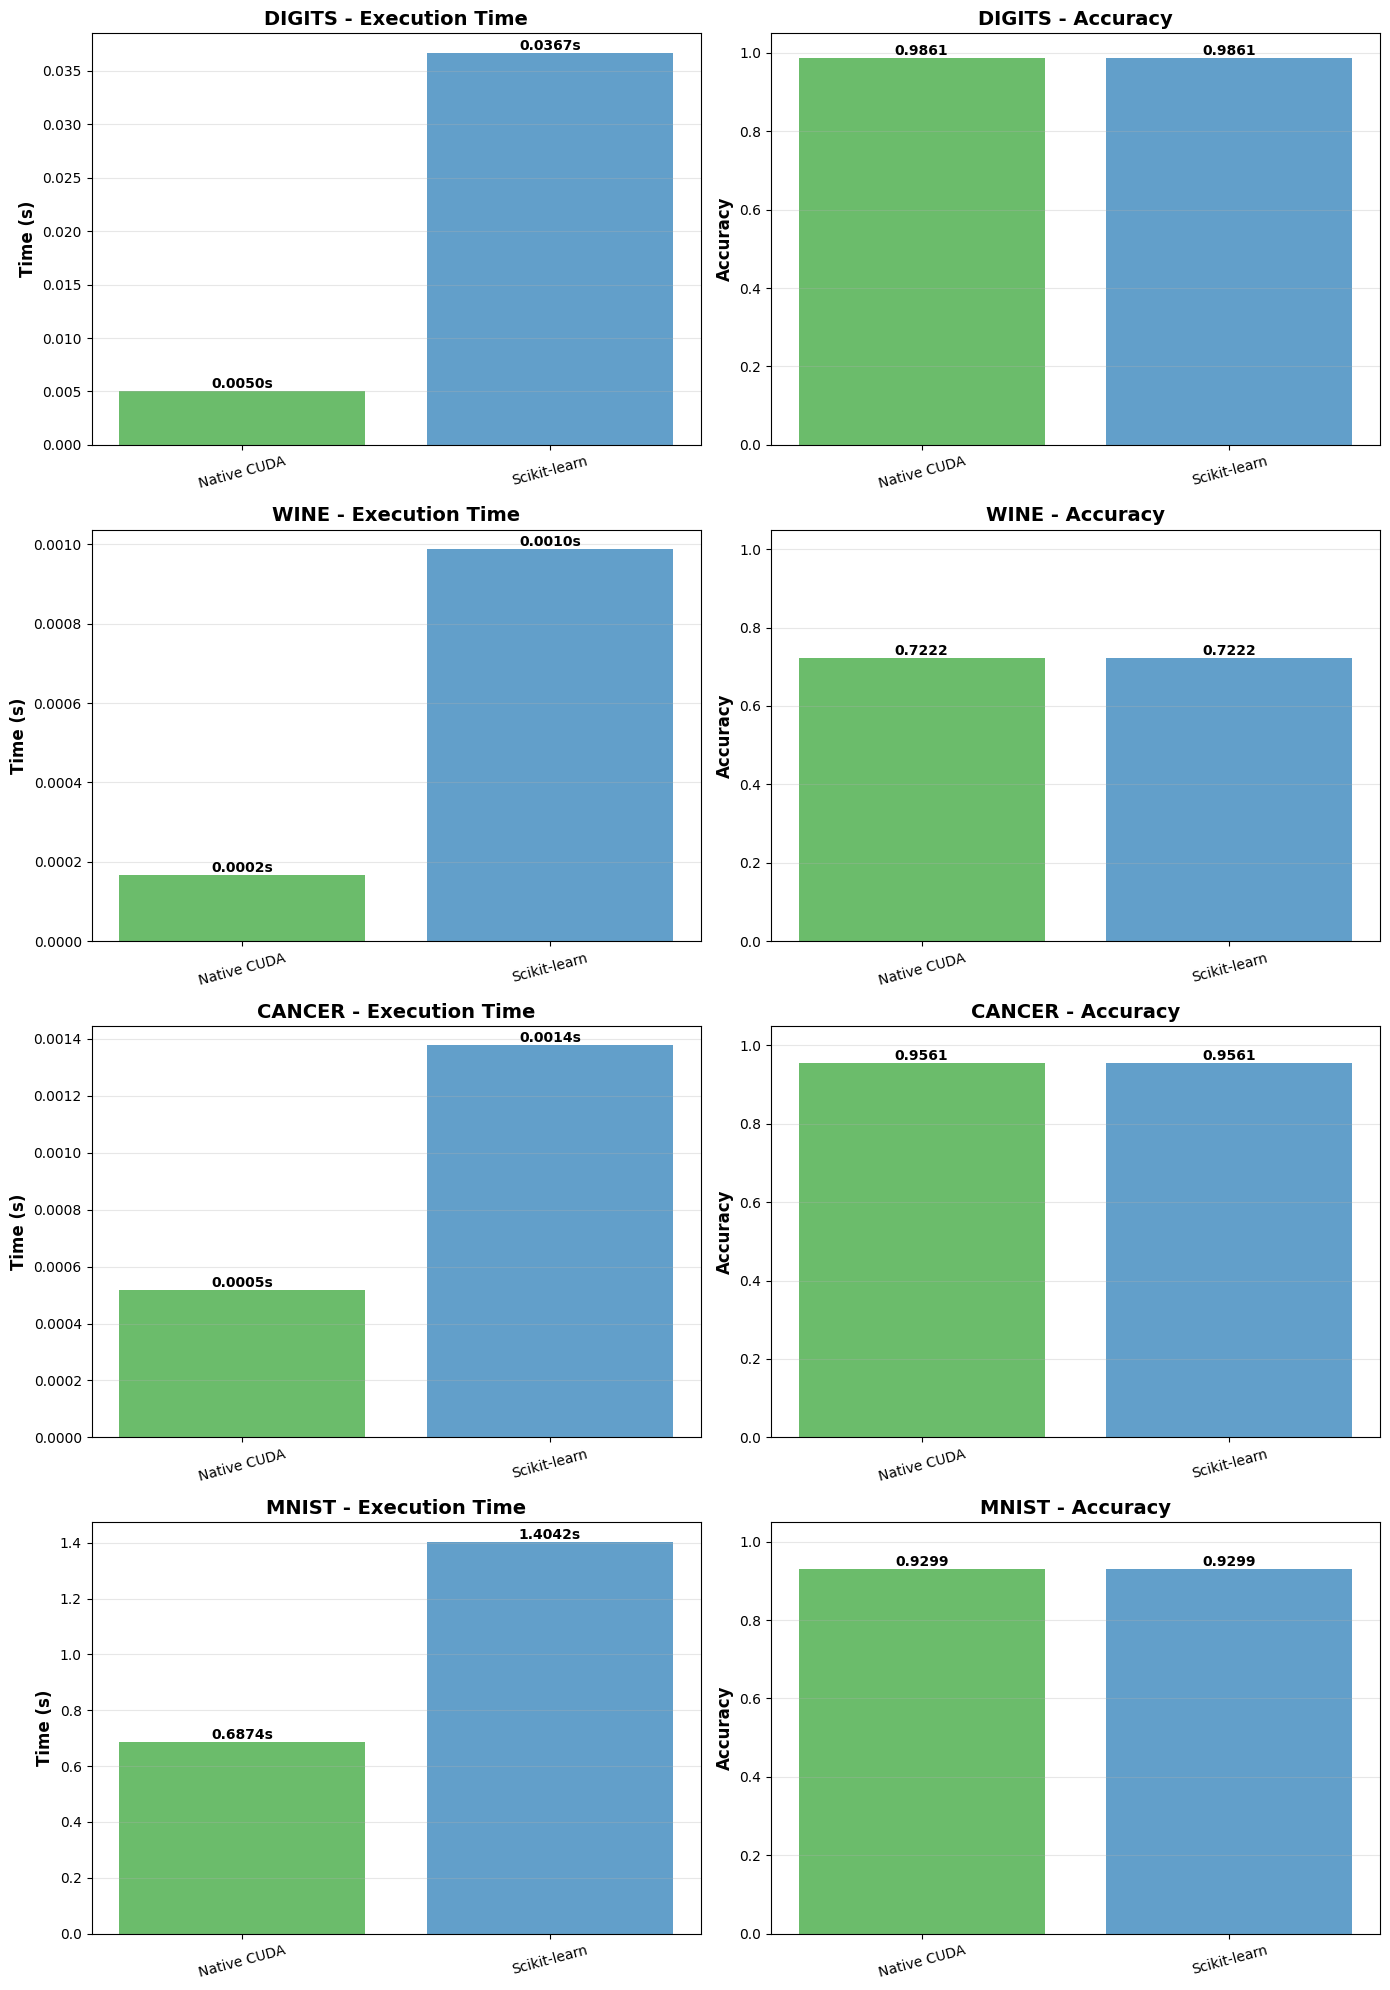

In [7]:
# Create subplots for each dataset
n_datasets = len(all_results)
fig, axes = plt.subplots(n_datasets, 2, figsize=(14, 5*n_datasets))

if n_datasets == 1:
    axes = axes.reshape(1, -1)

for idx, (dataset_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    times = [results[m]['time'] for m in methods]
    accuracies = [results[m]['accuracy'] for m in methods]

    # Time comparison
    ax1 = axes[idx, 0]
    bars = ax1.bar(methods, times, color=['tab:green', 'tab:blue'], alpha=0.7)
    ax1.set_ylabel('Time (s)', fontsize=12, fontweight='bold')
    ax1.set_title(f'{dataset_name.upper()} - Execution Time', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=15)
    ax1.grid(axis='y', alpha=0.3)

    # Add time labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.4f}s',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Accuracy comparison
    ax2 = axes[idx, 1]
    bars = ax2.bar(methods, accuracies, color=['tab:green', 'tab:blue'], alpha=0.7)
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title(f'{dataset_name.upper()} - Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1.05])
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(axis='y', alpha=0.3)

    # Add accuracy labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.4f}',
                     ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Performance Analysis


SPEEDUP ANALYSIS (Native CUDA vs Scikit-learn)
DIGITS         :   7.27x FASTER
  Scikit-learn: 0.0367s | Native CUDA: 0.0050s
WINE           :   5.91x FASTER
  Scikit-learn: 0.0010s | Native CUDA: 0.0002s
CANCER         :   2.66x FASTER
  Scikit-learn: 0.0014s | Native CUDA: 0.0005s
MNIST          :   2.04x FASTER
  Scikit-learn: 1.4042s | Native CUDA: 0.6874s


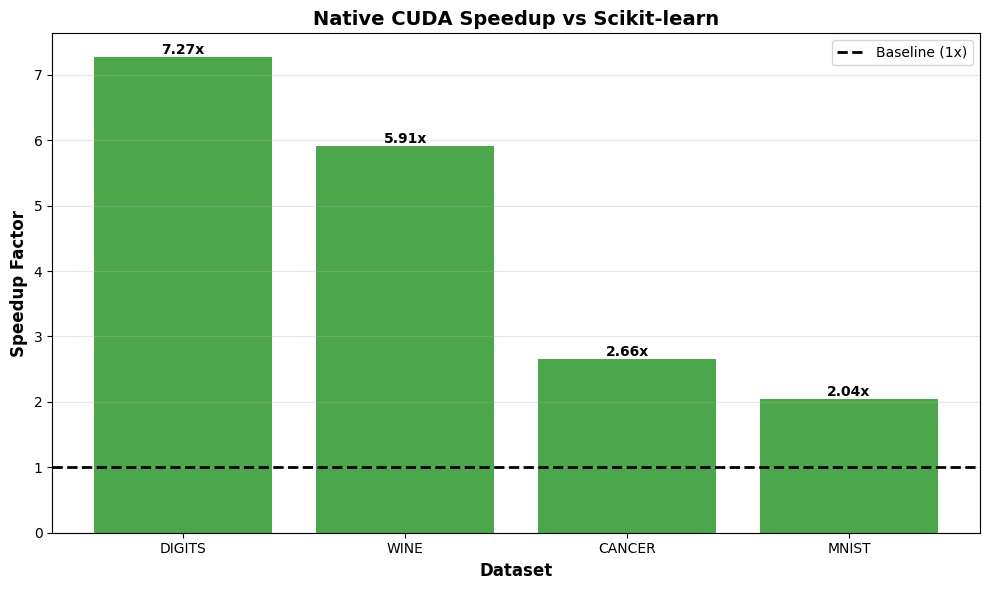

In [8]:
# Speedup Analysis
print("\n" + "="*80)
print("SPEEDUP ANALYSIS (Native CUDA vs Scikit-learn)")
print("="*80)

speedup_data = []
for dataset_name, results in all_results.items():
    sklearn_time = results['Scikit-learn']['time']
    cuda_time = results['Native CUDA']['time']

    if cuda_time > 0:
        speedup = sklearn_time / cuda_time
        speedup_data.append((dataset_name, speedup))
        print(f"{dataset_name.upper():15s}: {speedup:6.2f}x {'FASTER' if speedup > 1 else 'SLOWER'}")
        print(f"  Scikit-learn: {sklearn_time:.4f}s | Native CUDA: {cuda_time:.4f}s")
    else:
        print(f"{dataset_name.upper():15s}: N/A")

# Speedup visualization
if speedup_data:
    fig, ax = plt.subplots(figsize=(10, 6))
    datasets_names = [d[0].upper() for d in speedup_data]
    speedups = [d[1] for d in speedup_data]

    colors = ['green' if s > 1 else 'red' for s in speedups]
    bars = ax.bar(datasets_names, speedups, color=colors, alpha=0.7)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Baseline (1x)')
    ax.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_title('Native CUDA Speedup vs Scikit-learn', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

## 7. Dataset Characteristics Analysis

In [9]:
# Analyze how dataset size affects performance
print("\n" + "="*80)
print("DATASET CHARACTERISTICS")
print("="*80)

dataset_info = []
for dataset_name, data in datasets_dict.items():
    n_train = data['X_train'].shape[0]
    n_test = data['X_test'].shape[0]
    n_features = data['X_train'].shape[1]
    total_ops = n_test * n_train * n_features  # Approximate operations

    dataset_info.append({
        'name': dataset_name,
        'n_train': n_train,
        'n_test': n_test,
        'n_features': n_features,
        'total_ops': total_ops
    })

    print(f"\n{dataset_name.upper()}:")
    print(f"  Train samples: {n_train}")
    print(f"  Test samples: {n_test}")
    print(f"  Features: {n_features}")
    print(f"  Approx operations: {total_ops:,}")

    if dataset_name in all_results:
        cuda_time = all_results[dataset_name]['Native CUDA']['time']
        if cuda_time > 0:
            throughput = total_ops / cuda_time / 1e6  # Million ops per second
            print(f"  CUDA Throughput: {throughput:.2f} Million ops/sec")


DATASET CHARACTERISTICS

DIGITS:
  Train samples: 1437
  Test samples: 360
  Features: 64
  Approx operations: 33,108,480
  CUDA Throughput: 6561.33 Million ops/sec

WINE:
  Train samples: 142
  Test samples: 36
  Features: 13
  Approx operations: 66,456
  CUDA Throughput: 397.94 Million ops/sec

CANCER:
  Train samples: 455
  Test samples: 114
  Features: 30
  Approx operations: 1,556,100
  CUDA Throughput: 3004.05 Million ops/sec

MNIST:
  Train samples: 5000
  Test samples: 7000
  Features: 784
  Approx operations: 27,440,000,000
  CUDA Throughput: 39918.30 Million ops/sec


## 8. Summary Table

In [10]:
import pandas as pd

# Create summary table
summary_data = []
for dataset_name, results in all_results.items():
    data = datasets_dict[dataset_name]
    summary_data.append({
        'Dataset': dataset_name.upper(),
        'Samples': f"{data['X_train'].shape[0]}+{data['X_test'].shape[0]}",
        'Features': data['X_train'].shape[1],
        'CUDA Time (s)': f"{results['Native CUDA']['time']:.4f}",
        'CUDA Acc': f"{results['Native CUDA']['accuracy']:.4f}",
        'Sklearn Time (s)': f"{results['Scikit-learn']['time']:.4f}",
        'Sklearn Acc': f"{results['Scikit-learn']['accuracy']:.4f}",
        'Speedup': f"{results['Scikit-learn']['time'] / results['Native CUDA']['time']:.2f}x" if results['Native CUDA']['time'] > 0 else 'N/A'
    })

df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)
print(df.to_string(index=False))


COMPREHENSIVE SUMMARY
Dataset   Samples  Features CUDA Time (s) CUDA Acc Sklearn Time (s) Sklearn Acc Speedup
 DIGITS  1437+360        64        0.0050   0.9861           0.0367      0.9861   7.27x
   WINE    142+36        13        0.0002   0.7222           0.0010      0.7222   5.91x
 CANCER   455+114        30        0.0005   0.9561           0.0014      0.9561   2.66x
  MNIST 5000+7000       784        0.6874   0.9299           1.4042      0.9299   2.04x
